## 3.2 Number of titles published by protestant ministers per year

In this notebook a script is provided to get an graph on protestant ministers from CLERUS that published as main or co author over the years. The focus lies on the period until 1817, since we are using CLERUS_v1, yet it could easily be rerun on clerus_v2 once it is curated. The input data from the KB is processed in [2_5_Export_KB_data_nbt_authorinfo](../2_Linking_data/2_5_Export_KB_data_nbt_authorinfo.ipynb). 

Note that this is an example notebook in showing what the options are. Be aware that this linkage excludes all kind of possible links. For a computational historical analysis a more solid approach is needed with a clear research question.

In [1]:
# Load CLERUS database

import pyodbc
import pandas as pd
import re
import numpy as np
import csv
import matplotlib.pyplot as plt

# Function to load all tables as panda dataframes from an access database
def export_access_to_dataframes(database_path):
    # Connection string for Access database
    conn_str = (
        r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
        r'DBQ=' + database_path + ';'
    )

    # Establish a connection to the Access database
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()

    # Get a list of all tables in the database
    tables = [row.table_name for row in cursor.tables(tableType='TABLE')]

    # Loop through the tables and load each into a DataFrame
    for table in tables:
        query = f'SELECT * FROM [{table}]'
        df = pd.read_sql(query, conn)
        globals()[f'tbl_{table}'] = df  # Create a global variable with the table name

    # Close the connection
    conn.close()

# Provided path to CLERUS access database (if needed there is also a .sql dump of the access database) 
clerus_db = '..\data\input\CLERUS_v1_DRC_07082024.accdb'

# load database tables as panda dataframes
export_access_to_dataframes(clerus_db)

C:\Users\Maurice de Kleijn\AppData\Local\Temp\ipykernel_18536\3793384337.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Maurice de Kleijn\AppData\Local\Temp\ipykernel_18536\3793384337.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Maurice de Kleijn\AppData\Local\Temp\ipykernel_18536\3793384337.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Maurice de Kleijn\AppData\Local\Temp\ipykernel_18536

In [2]:
# Load Book title data in pandas dataframe 
# Make sure to update the name according to the names generated in the output of ..\2_Linking_data\2_5_Export_KB_data_nbt_authorinfo.ipynb

authors_path = '..\\data\\output\\nbt_books_authors_08082024.csv'
authors = pd.read_csv(authors_path, sep=';', encoding='utf-8')

co_authors_path = '..\\data\\output\\nbt_books_co_authors_08082024.csv'
co_authors = pd.read_csv(co_authors_path, sep=';', encoding='utf-8')

book_info_path = '..\\data\\output\\nbt_books_08082024.csv'
book_info = pd.read_csv(book_info_path, sep=';', encoding='utf-8')


In [3]:
# Panda settings for showing data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
def split_name_column(row):
    if isinstance(row, str):
        try:
            surname, rest = row.split(', ')
            if ' (' in rest:
                first_name, years = rest.split(' (')
                first_letter = first_name[0]
                birth_year, death_year = years.strip(')').split('-')
                return pd.Series([surname, first_name, first_letter, birth_year, death_year])
            else:
                first_name = rest
                first_letter = first_name[0]
                return pd.Series([surname, first_name, first_letter, None, None])
        except ValueError:
            return pd.Series([None, None, None, None, None])
    else:
        return pd.Series([None, None, None, None, None])

In [5]:
authors[['surname', 'first_name', 'first_letter', 'birth_year', 'death_year']] = authors['author'].apply(split_name_column)
authors['authorship'] = "main author"
authors.rename(columns={'author': 'bio'}, inplace=True)

co_authors[['surname', 'first_name', 'first_letter', 'birth_year', 'death_year']] = co_authors['co_author'].apply(split_name_column)
co_authors.rename(columns={'co_author': 'bio'}, inplace=True)
co_authors['authorship'] = "co author"

In [6]:
book_authors = pd.concat([authors, co_authors], ignore_index=True)
book_authors['book_join_fld'] = (book_authors['first_letter'].astype(str) + '_' + book_authors['surname'].astype(str) + '_' + np.where(book_authors['birth_year'].isna(), '', book_authors['birth_year'].astype(str)))

In [7]:
# Link publication year to authors of books
book_pub_year = book_info[['title_id','pub_year']]
book_authors_py = pd.merge(book_authors, book_pub_year, left_on='title_id', right_on='title_id', how='left')

In [8]:
# For the purpose of this example we map the first letter, surname and year of birth between CLERUS_v1 and the NBT output. 
# Obviously this will not contain all the matching persons, since CLERUS might in some occasions have a different spelling and the KB as well. 
# To solve this methods like Levensthein can be applied combined with sampling the data for expert assessment to estimate the reliability of the analysis.
# Step 1: create a join string from tbl_01_clerus_bio

tbl_01_clerus_bio['first_letter'] = tbl_01_clerus_bio['first_name'].astype(str).apply(lambda x: x[0])
tbl_01_clerus_bio['birth_year'] = tbl_01_clerus_bio['birth_year'].astype(str)
tbl_01_clerus_bio['birth_year']= tbl_01_clerus_bio['birth_year'].str.extract(r'(\d{4})')
tbl_01_clerus_bio['clerus_join_fld'] = (tbl_01_clerus_bio['first_letter'].astype(str) + '_' + tbl_01_clerus_bio['surname'].astype(str) + '_' + np.where(tbl_01_clerus_bio['birth_year'].isna(), '', tbl_01_clerus_bio['birth_year'].astype(str)))

In [9]:
# Here a left join is made between book_authors and tbl_01_clerus_bio. This keeps all book records and adds only clerus ministers that are matched.
clerus_books_links = pd.merge(book_authors_py, tbl_01_clerus_bio, left_on='book_join_fld', right_on='clerus_join_fld', how='left')

In [10]:
# Now a subselection is made for all books that are linked with a clerus individual
clerus_authors = clerus_books_links.dropna(subset=['clerus_join_fld'])

# This however does provide a lot of useless links especially when a birth year is unknown. For instance J_Janssen_ matches obiously between the two datasets. It could have been solves by not creating the string above, however some individuals are indeed unique.
clerus_authors_by = clerus_authors[clerus_authors['clerus_join_fld'].str.contains(r'\d{4}', regex=True)]

In [11]:
# Since the KB dataset used X when publication year is uncertain we decided to replace these for a 0 (an other option would be to exclude them)
clerus_authors_by['pub_year'] = clerus_authors_by['pub_year'].fillna('0').str.replace('X', '0')
clerus_authors_by['pub_year_int'] = clerus_authors_by['pub_year'].astype(int)

C:\Users\Maurice de Kleijn\AppData\Local\Temp\ipykernel_18536\2221247729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clerus_authors_by['pub_year'] = clerus_authors_by['pub_year'].fillna('0').str.replace('X', '0')
C:\Users\Maurice de Kleijn\AppData\Local\Temp\ipykernel_18536\2221247729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clerus_authors_by['pub_year_int'] = clerus_authors_by['pub_year'].astype(int)


In [12]:
# exclude all pub_years that are 0
clerus_authors_by = clerus_authors_by[clerus_authors_by['pub_year_int'] != 0]

In [13]:
# seperate main and co authors
clerus_main_authors = clerus_authors_by[clerus_authors_by['authorship'] == 'main author']['pub_year_int'].value_counts().sort_index()
clerus_co_authors = clerus_authors_by[clerus_authors_by['authorship'] == 'co author']['pub_year_int'].value_counts().sort_index()

all_years = sorted(set(clerus_main_authors.index).union(set(clerus_co_authors.index)))
clerus_main_authors = clerus_main_authors.reindex(all_years, fill_value=0)
clerus_co_authors = clerus_co_authors.reindex(all_years, fill_value=0)

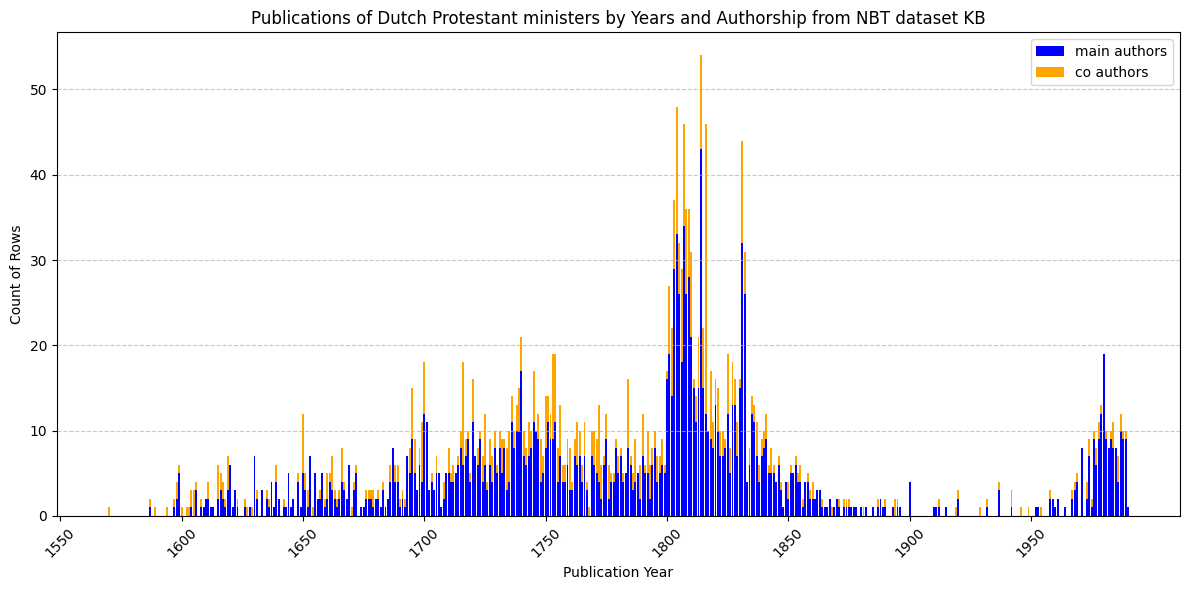

In [16]:
# Plot stacked bars
plt.figure(figsize=(12, 6))
bar_width = 0.8

p1 = plt.bar(clerus_main_authors.index, clerus_main_authors.values, bar_width, label='main authors', color='blue')
p2 = plt.bar(clerus_co_authors.index, clerus_co_authors.values, bar_width, bottom=clerus_main_authors.values, label='co authors', color='orange')

plt.xlabel('Publication Year')
plt.ylabel('Count of Rows')
plt.title('Publications of Dutch Protestant ministers by Years and Authorship from NBT dataset KB')
plt.xticks(rotation=45)

# Set the custom x-axis ticks
custom_ticks = list(range(1550, 2000, 50))
plt.gca().set_xticks(custom_ticks)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()